In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
PATH = Path('../data/')
TRAIN_PATH = PATH/'train_images'
TEST_PATH_1 = PATH/'leaderboard_test_data'
TEST_PATH_2 = PATH/'leaderboard_holdout_data'

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.4, max_zoom=1.05, max_warp=0., 
                      p_affine=1., p_lighting=0.)

In [5]:
np.random.seed(0)

src = (ImageItemList.from_csv(PATH, 'traininglabels.csv', folder='train_images')
                    .random_split_by_pct(0.2)
                    .label_from_df(cols=1))

In [6]:
bs = 32
data = (src.transform(tfms, size=128)
           .databunch(bs=bs)
           .normalize(imagenet_stats))

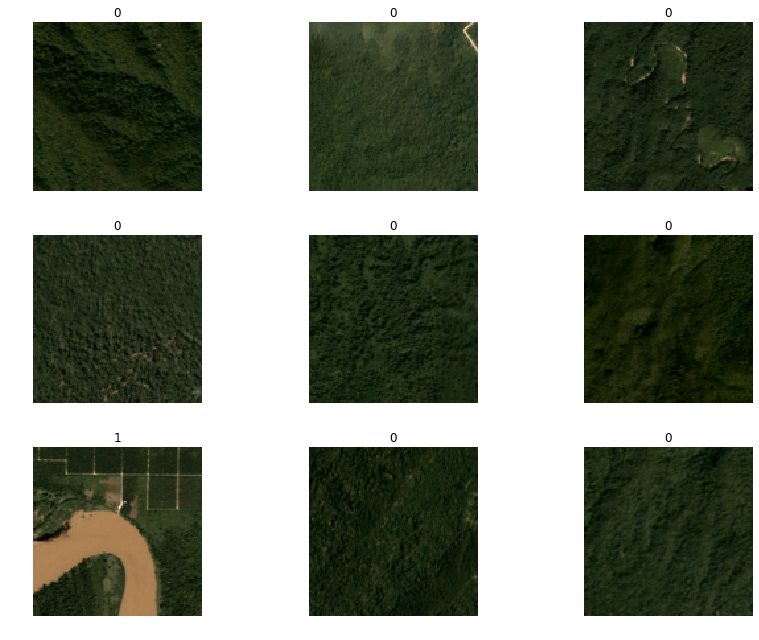

In [7]:
data.show_batch(rows=3, figsize=(12,9))

In [10]:
arch = models.resnet50

In [11]:
learn = create_cnn(data, arch, metrics=accuracy)

In [ ]:
learn.lr_find()

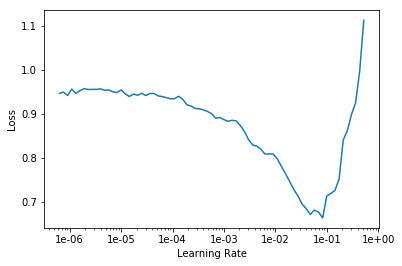

In [11]:
learn.recorder.plot()

In [12]:
lr = 1e-2

In [13]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.066865,0.043104,0.987205
2,0.044015,0.034526,0.990157
3,0.042939,0.038116,0.989173
4,0.027184,0.038376,0.988189
5,0.025124,0.032098,0.990157


In [14]:
learn.save('stage-1-rn50')

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


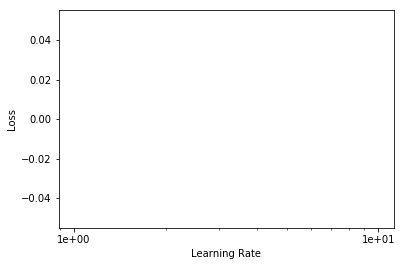

In [17]:
learn.lr_find(start_lr=1e-7, end_lr=1e-1)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.062050,0.040774,0.990814
2,0.060108,0.075515,0.977690
3,0.048102,0.041860,0.984908
4,0.039184,0.022326,0.993110
5,0.022381,0.218064,0.989501


In [19]:
learn.save('stage-2-rn50')

In [21]:
data = (src.transform(tfms, size=256)
           .databunch(bs=32)
           .normalize(imagenet_stats))
learn.data = data

In [22]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


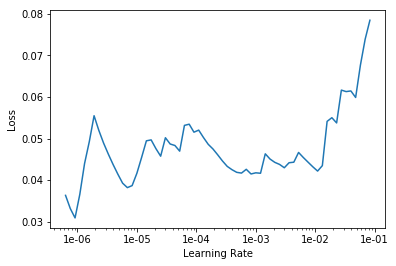

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
lr=1e-3

In [25]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy
1,0.027079,0.041822,0.989173
2,0.031363,0.043859,0.988517
3,0.024834,0.029240,0.988845
4,0.027134,0.028255,0.989829
5,0.024327,0.029901,0.988845


In [26]:
learn.save('stage-1-256-rn50')

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.027411,0.028700,0.990157
2,0.024005,0.027412,0.990157
3,0.025120,0.026646,0.990814
4,0.025310,0.028956,0.989829
5,0.020159,0.028298,0.990486


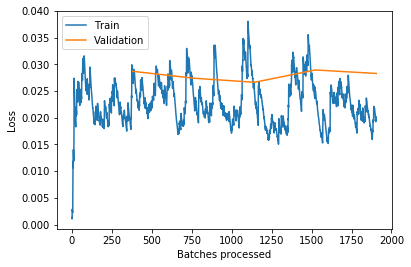

In [29]:
learn.recorder.plot_losses()

In [30]:
learn.save('stage-2-256-rn50')

# Test

In [59]:
learn = create_cnn(data, arch, metrics=accuracy)

In [60]:
learn = learn.load('stage-2-256-rn50')

In [61]:
learn.export()

In [62]:
test_1 = ImageItemList.from_folder(TEST_PATH_1)
test_2 = ImageItemList.from_folder(TEST_PATH_2)
len(test_1), len(test_2)

(4356, 2178)

In [63]:
learn_1 = load_learner(PATH, test=test_1)
preds_1, _ = learn_1.get_preds(ds_type=DatasetType.Test)

In [64]:
out_1 = preds_1[:, 1]

In [65]:
fnames_1 = [str(f).split('/')[-1] for f in learn_1.data.test_ds.items]
df_1 = pd.DataFrame({'image_id':fnames_1, 'has_oilpalm':out_1}, columns=['image_id', 'has_oilpalm'])

In [66]:
df_1.head(5)

,image_id,has_oilpalm
0,img_006952017.jpg,0.000022
1,img_050972018.jpg,0.686701
2,img_078702018.jpg,0.000547
3,img_043442017.jpg,0.551207
4,img_061632017.jpg,0.025569


In [67]:
learn_2 = load_learner(PATH, test=test_2)
preds_2, _ = learn_2.get_preds(ds_type=DatasetType.Test)

In [68]:
out_2 = preds_2[:, 1]

In [69]:
fnames_2 = [str(f).split('/')[-1] for f in learn_2.data.test_ds.items]
df_2 = pd.DataFrame({'image_id':fnames_2, 'has_oilpalm':out_2}, columns=['image_id', 'has_oilpalm'])

In [70]:
df_2.head(5)

,image_id,has_oilpalm
0,img_087262018.jpg,0.139155
1,img_084402018.jpg,0.001944
2,img_035082017.jpg,0.047853
3,img_004842018.jpg,0.000673
4,img_000772018.jpg,0.000259


In [71]:
df_out = pd.concat([df_1, df_2], axis=0).sort_values('image_id').reset_index(drop=True)

In [72]:
df_out.shape

(6534, 2)

In [73]:
df_out.head(10)

,image_id,has_oilpalm
0,img_000012018.jpg,5.351944e-01
1,img_000022018.jpg,1.956794e-04
2,img_000032017.jpg,9.665045e-01
3,img_000042017.jpg,7.017751e-01
4,img_000052017.jpg,3.730895e-08
5,img_000062017.jpg,5.749481e-04
6,img_000062018.jpg,1.746842e-01
7,img_000122017.jpg,2.850789e-06
8,img_000132018.jpg,9.970619e-01
9,img_000142018.jpg,3.221644e-02


In [74]:
df_out.to_csv('./test_output.csv', index=False)